In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
import time
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr
from astropy.convolution import Gaussian2DKernel, convolve

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5_U = ERA5["u"].sel(valid_time="2024-04-02T12:00:00", pressure_level=500)

In [4]:
ERA5_U.shape

(721, 1440)

In [5]:
import copy


def plot_data(
    da: xr.DataArray,
    title_prefix="",
    title_postfix="",
    error=False,
    n_levels=256,
    cmap=None,
    divergence_point=None,
    levels=None,
    chart=None,
    **kwargs,
):
    UNITS = dict(t2m="degC")
    DIVERGENCE_POINT = dict(t2m=0.0)

    units = None if error else UNITS.get(da.name, None)
    divergence_point = (
        divergence_point
        if divergence_point is not None
        else 0.0
        if error
        else DIVERGENCE_POINT.get(da.name, None)
    )

    source = earthkit.plots.sources.XarraySource(da)

    # compute the default style that earthkit.maps would apply
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=units or source.units,
        )
    )

    da_units = style.convert_units(da.values, source.units)

    # modify the style levels to get a smoother colourbar
    style._levels = earthkit.plots.styles.levels.Levels(
        levels
        if levels is not None
        else earthkit.plots.styles.levels.auto_range(
            da_units,
            divergence_point=divergence_point,
            n_levels=n_levels,
        )
    )
    style._legend_kwargs["ticks"] = earthkit.plots.styles.levels.auto_range(
        da_units,
        divergence_point=divergence_point,
        n_levels=10,
    )

    style._kwargs.update(kwargs)

    # force the colourmap to coolwarm for error plots
    style._colors = cmap if cmap is not None else "coolwarm" if error else style._colors

    show = chart is None
    if chart is None:
        chart = earthkit.plots.Map()

    # quickplot with the modified style
    chart.quickplot(
        da,
        units=units,
        style=style,
    )

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    chart.title(
        f"{title_prefix}{{variable_name}} on {{time:%d.%m.%Y at %H:%M}}{title_postfix}"
    )

    if show:
        chart.show()

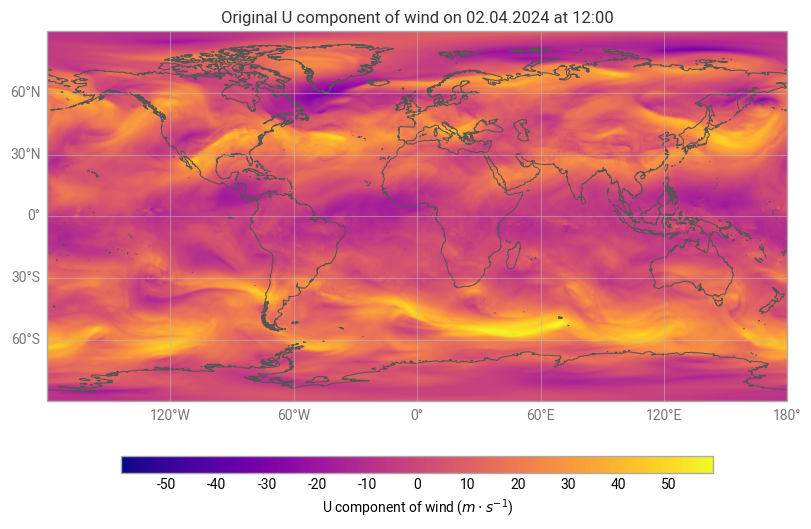

In [6]:
plot_data(ERA5_U, title_prefix="Original ", divergence_point=0)

In [7]:
def dssim(
    a1: np.ndarray,
    a2: np.ndarray,
    eps: float = 1e-8,
    kernel_size: int = 11,
) -> float:
    """
    Implementation adapted from the official dSSIM implementation at
    https://github.com/NCAR/ldcpy/blob/6c5bcb8149ec7876a4f53b0e784e9c528f6f14cb/ldcpy/calcs.py#L2516

    The official implementation makes assumptions about the input data that are
    specific to models developed at NCAR which is why we cannot use the official
    implementation directly.

    Parameters
    ----------
    x : np.ndarray
        Shape: (latitude, longitude)
    y : np.ndarray
        Shape: (latitude, longitude)
    kernel_size : int
        The size of the Gaussian kernel for the convolution operation in SSIM. Has to be
        an odd number. The default is 11.

    Returns
    -------
    float
        The data-SSIM value between the two input arrays.
    """
    assert kernel_size % 2 == 1, "kernel_size must be an odd number."

    # re-scale  to [0,1] - if not constant
    smin = min(np.nanmin(a1), np.nanmin(a2))
    smax = max(np.nanmax(a1), np.nanmax(a2))
    r = smax - smin
    if r == 0.0:  # scale by smax if field is a constant (and smax != 0)
        if smax == 0.0:
            sc_a1 = a1
            sc_a2 = a2
        else:
            sc_a1 = a1 / smax
            sc_a2 = a2 / smax
    else:
        sc_a1 = (a1 - smin) / r
        sc_a2 = (a2 - smin) / r

    # now quantize to 256 bins
    sc_a1 = np.round(sc_a1 * 255) / 255
    sc_a2 = np.round(sc_a2 * 255) / 255

    # gaussian filter
    kernel = Gaussian2DKernel(x_stddev=1.5, x_size=kernel_size, y_size=kernel_size)
    filter_args = {"boundary": "fill", "preserve_nan": True}

    a1_mu = convolve(sc_a1, kernel, **filter_args)
    a2_mu = convolve(sc_a2, kernel, **filter_args)

    a1a1 = convolve(sc_a1 * sc_a1, kernel, **filter_args)
    a2a2 = convolve(sc_a2 * sc_a2, kernel, **filter_args)

    a1a2 = convolve(sc_a1 * sc_a2, kernel, **filter_args)

    ###########
    var_a1 = a1a1 - a1_mu * a1_mu
    var_a2 = a2a2 - a2_mu * a2_mu
    cov_a1a2 = a1a2 - a1_mu * a2_mu

    # ssim constants
    C1 = eps
    C2 = eps

    ssim_t1 = 2 * a1_mu * a2_mu + C1
    ssim_t2 = 2 * cov_a1a2 + C2

    ssim_b1 = a1_mu * a1_mu + a2_mu * a2_mu + C1
    ssim_b2 = var_a1 + var_a2 + C2

    ssim_1 = ssim_t1 / ssim_b1
    ssim_2 = ssim_t2 / ssim_b2
    ssim_mat = ssim_1 * ssim_2

    # Cropping the border region of the 2D field where the convolution kernel is not
    # fully overlapping with the 2D input field.
    k = (kernel_size - 1) // 2
    ssim_mat = ssim_mat[k : ssim_mat.shape[0] - k, k : ssim_mat.shape[1] - k]
    return np.nanmean(ssim_mat)

In [8]:
dssim(ERA5_U.values, ERA5_U.values)

np.float32(1.0)

In [9]:
from numcodecs_wasm_zfp import Zfp

In [10]:
zfp = Zfp(mode="fixed-accuracy", tolerance=1)

In [11]:
ERA5_U_zfp = ERA5_U.copy(data=zfp.decode(zfp.encode(ERA5_U.values)))

In [12]:
np.amax(np.abs(ERA5_U - ERA5_U_zfp)).item()

0.5431060791015625

In [13]:
dssim(ERA5_U.values, ERA5_U_zfp.values)

np.float32(0.95741546)

In [14]:
from compression_safeguards import Safeguards
from compression_safeguards.utils.bindings import Bindings

In [15]:
prediction = np.zeros_like(ERA5_U.values)

In [16]:
# Baker et al. (2023) On a Structural Similarity Index Approach for Floating-Point Data
for dssim_bound in [0.99, 0.995, 0.99919]:
    sg = Safeguards(
        safeguards=[
            dict(kind="sign", offset="$x_min"),
            dict(kind="sign", offset="$x_max"),
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                let(
                    # we guarantee that
                    #  min(data) = min(corrected) and
                    #  max(data) = max(corrected)
                    # with the sign safeguards above
                    V["smin"], c["$x_min"],
                    V["smax"], c["$x_max"],
                )(let(
                    V["r"], V["smax"] - V["smin"],
                )
                
                (let(
                    # re-scale to [0-1] and quantize to 256 bins
                    V["sc_a1"], round_ties_even((C["$X"] - V["smin"]) / V["r"] * 255) / 255,
                    V["sc_a2"], round_ties_even((X - V["smin"]) / V["r"] * 255) / 255,
                )
    
                (let(
                    # create a 2D 11x11 Gaussian kernel
                    V["i"], A[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
                )(let(
                    V["k"], 1/(sqrt(2*pi)*c["sigma"]) * exp((-V["i"]**2) / (2*c["sigma"]**2)),
                )(let(
                    V["k_norm"], V["k"] / asum(V["k"]),
                )(let(
                    V["kernel"], matmul(tr(A[V["k_norm"]]), A[V["k_norm"]]),
                )
    
                (let(
                    # apply the Gaussian filter
                    V["a1_mu"], matmul(V["sc_a1"], V["kernel"])[0,0],
                    V["a2_mu"], matmul(V["sc_a2"], V["kernel"])[0,0],
                    V["a1a1"], matmul(V["sc_a1"]**2, V["kernel"])[0,0],
                    V["a2a2"], matmul(V["sc_a2"]**2, V["kernel"])[0,0],
                    V["a1a2"], matmul(V["sc_a1"] * V["sc_a2"], V["kernel"])[0,0],
                )
    
                (let(
                    ###########
                    V["var_a1"], V["a1a1"] - V["a1_mu"]**2,
                    V["var_a2"], V["a2a2"] - V["a2_mu"]**2,
                    V["cov_a1a2"], V["a1a2"] - V["a1_mu"] * V["a2_mu"],
                )
    
                (let(
                    # compute the SSIM components
                    V["ssim_t1"], 2 * V["a1_mu"] * V["a2_mu"] + c["C1"],
                    V["ssim_t2"], 2 * V["cov_a1a2"] + c["C2"],
                    V["ssim_b1"], V["a1_mu"]**2 + V["a2_mu"]**2 + c["C1"],
                    V["ssim_b2"], V["var_a1"] + V["var_a2"] + c["C2"],
                )
    
                (let(
                    V["ssim_1"], V["ssim_t1"] / V["ssim_b1"],
                    V["ssim_2"], V["ssim_t2"] / V["ssim_b2"],
                )
                
                (
                    # compute the pointwise dSSIM
                    V["ssim_1"] * V["ssim_2"]
                )))))))))))
                """,
                type="abs",
                eb=1 - dssim_bound,
                # 11x11 neighbourhood
                neighbourhood=[
                    # latitude
                    dict(axis=0, before=5, after=5, boundary="valid"),
                    # longitude
                    dict(axis=1, before=5, after=5, boundary="valid"),
                ],
            ),
        ],
    )

    start = time.perf_counter()
    correction_sg = sg.compute_correction(
        ERA5_U.values,
        prediction,
        late_bound=Bindings(
            **{
                "$x_min": np.nanmin(ERA5_U),
                "$x_max": np.nanmax(ERA5_U),
            },
            sigma=np.array(1.5, dtype=ERA5_U.dtype)[()],
            C1=np.array(1e-8, dtype=ERA5_U.dtype)[()],
            C2=np.array(1e-8, dtype=ERA5_U.dtype)[()],
        ),
    )
    end = time.perf_counter()

    ERA5_U_sg = ERA5_U.copy(data=sg.apply_correction(prediction, correction_sg))

    print(
        f"dSSIM >= {dssim_bound}: abs={np.amax(np.abs(ERA5_U - ERA5_U_sg)).item()} dSSIM={dssim(ERA5_U.values, ERA5_U_sg.values)} time={end - start}s"
    )

eb: 1975.9988993340012s
-0.25725335 -5.2452087e-06 0.00036981302804087613
1.3649464e-05 0.34461403 0.0
idx: 73.67917550000129s
dSSIM >= 0.99: abs=0.1876378059387207 dSSIM=0.9999809861183167 time=2059.5668562079954s
eb: 1967.3067803340018s
-0.25725335 -5.2452087e-06 0.00036981302804087613
1.3649464e-05 0.34461403 0.0
idx: 73.48432875000435s
dSSIM >= 0.995: abs=0.1876378059387207 dSSIM=0.9999809861183167 time=2051.1019328750044s
eb: 1911.4956363340025s
-0.25725335 -5.2452087e-06 0.00036981302804087613
1.3649464e-05 0.34461403 0.0
idx: 73.11911525000323s
dSSIM >= 0.99919: abs=0.1876378059387207 dSSIM=0.9999809861183167 time=1993.8390955840005s


In [17]:
print(sg.safeguards[-1]._qoi_expr)

((exp(-13/c["sigma"][5, 5]**2)*round_ties_even(255*(C["$X"][0, 4] - c["$x_min"][5, 5])/(c["$x_max"][5, 5] - c["$x_min"][5, 5]))/(255*pi*(sqrt(2)/(2*sqrt(pi)*c["sigma"][5, 5]) + sqrt(2)*exp(-2/c["sigma"][5, 5]**2)/(sqrt(pi)*c["sigma"][5, 5]) + sqrt(2)*exp(-8/c["sigma"][5, 5]**2)/(sqrt(pi)*c["sigma"][5, 5]) + sqrt(2)*exp(-1/(2*c["sigma"][5, 5]**2))/(sqrt(pi)*c["sigma"][5, 5]) + sqrt(2)*exp(-9/(2*c["sigma"][5, 5]**2))/(sqrt(pi)*c["sigma"][5, 5]) + sqrt(2)*exp(-25/(2*c["sigma"][5, 5]**2))/(sqrt(pi)*c["sigma"][5, 5]))**2*c["sigma"][5, 5]**2) + exp(-13/c["sigma"][5, 5]**2)*round_ties_even(255*(C["$X"][0, 6] - c["$x_min"][5, 5])/(c["$x_max"][5, 5] - c["$x_min"][5, 5]))/(255*pi*(sqrt(2)/(2*sqrt(pi)*c["sigma"][5, 5]) + sqrt(2)*exp(-2/c["sigma"][5, 5]**2)/(sqrt(pi)*c["sigma"][5, 5]) + sqrt(2)*exp(-8/c["sigma"][5, 5]**2)/(sqrt(pi)*c["sigma"][5, 5]) + sqrt(2)*exp(-1/(2*c["sigma"][5, 5]**2))/(sqrt(pi)*c["sigma"][5, 5]) + sqrt(2)*exp(-9/(2*c["sigma"][5, 5]**2))/(sqrt(pi)*c["sigma"][5, 5]) + sqrt(2)*